MACHINE LEARNING MODEL FOR STOCKS RETURN PREDICTIONS BY FINANCIAL FUNDAMENTALS

Part 2: DATA PREPROCESSING AND MODEL BUILDING.

---

There is plenty to do with the newly scraped data.

To try list in case of poor performance


1.   Try using the exact initial date for features calculation which use stock price.
2.   Add original accounts as features
3. Remove examples with initial price = 0 ( Stocks which start to be public less than 4 year ago) 
4. Remove examples with final price = 0 (stocks that presented their last statms 2.5 or less months ago)
5. Research if outliers resulted from followed accounts changes (e,g: 100% or -100%) should be removed.



In [2]:
#Import needed libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Fundamentals_FinalDF.csv to Fundamentals_FinalDF.csv


In [4]:
import io
First_df = pd.read_csv(io.BytesIO(uploaded['Fundamentals_FinalDF.csv']))
First_df

,stock,endDate,netIncome,totalRevenue,ebit,researchDevelopment,operatingIncome,interestExpense,totalAssets,totalLiab,totalCurrentLiabilities,totalCurrentAssets,repurchaseOfStock,Initial Prices,Final Prices,Ordinary Shares Number,Total Debt,Free Cash Flow
0,MSFT,2020-06-30,4.428100e+10,1.430150e+11,5.295900e+10,1.926900e+10,5.295900e+10,-2.591000e+09,3.013110e+11,1.830070e+11,7.231000e+10,1.819150e+11,-2.296800e+10,194.240005,208.779999,7571000.0,70998000.0,45234000.0
1,MSFT,2019-06-30,3.924000e+10,1.258430e+11,4.295900e+10,1.687600e+10,4.295900e+10,-2.686000e+09,2.865560e+11,1.842260e+11,6.942000e+10,1.755520e+11,-1.954300e+10,132.850006,136.330002,7643000.0,78366000.0,38260000.0
2,MSFT,2018-06-30,1.657100e+10,1.103600e+11,3.505800e+10,1.472600e+10,3.505800e+10,-2.733000e+09,2.588480e+11,1.761300e+11,5.848800e+10,1.696620e+11,-1.072100e+10,100.860001,112.139999,7677000.0,81808000.0,32252000.0
3,MSFT,2017-06-30,2.548900e+10,9.657100e+10,2.933100e+10,1.303700e+10,2.933100e+10,-2.222000e+09,2.503120e+11,1.626010e+11,5.574500e+10,1.626960e+11,-1.178800e+10,70.870003,75.309998,7708000.0,86194000.0,31378000.0
4,T,2020-12-31,-5.176000e+09,1.717600e+11,2.565600e+10,NaN,2.565600e+10,-7.925000e+09,5.257610e+11,3.465210e+11,6.343800e+10,5.200800e+10,-5.498000e+09,29.400000,30.010000,7125922.0,179447000.0,27455000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,HERDEZ.MX,2017-12-31,1.046111e+09,2.006492e+10,2.812898e+09,NaN,2.812898e+09,-5.734910e+08,2.784602e+10,1.050422e+10,3.123141e+09,8.254989e+09,-1.551190e+08,45.730000,46.980000,428549.0,6350785.0,1327645.0
250,NTDOY,2020-03-31,2.586410e+11,1.308519e+12,3.523710e+11,8.412700e+10,3.523710e+11,NaN,1.934087e+12,3.931870e+11,3.556830e+11,1.501583e+12,-4.300000e+07,40.709999,55.700001,119124.0,NaN,337910000.0
251,NTDOY,2019-03-31,1.940090e+11,1.200560e+12,2.497020e+11,6.962400e+10,2.497020e+11,NaN,1.690304e+12,2.755060e+11,2.450090e+11,1.344972e+12,-3.103800e+10,35.889999,43.180000,119125.0,NaN,159792000.0
252,NTDOY,2018-03-31,1.395900e+11,1.055682e+12,1.775580e+11,6.399900e+10,1.775580e+11,NaN,1.633748e+12,3.101730e+11,2.780760e+11,1.276764e+12,-7.800000e+07,56.400002,41.650002,120126.0,NaN,142599000.0


In [5]:
First_df.loc[First_df['Initial Prices'] == 0]

,stock,endDate,netIncome,totalRevenue,ebit,researchDevelopment,operatingIncome,interestExpense,totalAssets,totalLiab,totalCurrentLiabilities,totalCurrentAssets,repurchaseOfStock,Initial Prices,Final Prices,Ordinary Shares Number,Total Debt,Free Cash Flow
217,DBX,2017-12-31,-111700000.0,1.106800e+09,-113700000.0,380300000.0,-113700000.0,-14000000.0,1.019900e+09,9.170000e+08,7.384000e+08,5.181000e+08,-87900000.0,0.0,28.48,395000.0,174300.0,304200.0
225,PAGS,2017-12-31,478781000.0,2.514809e+09,779521000.0,NaN,779521000.0,-104544000.0,4.235757e+09,3.365366e+09,3.318967e+09,4.027953e+09,-39532000.0,0.0,33.41,262289.0,0.0,346069.0


In [6]:
First_df.loc[First_df['Final Prices'] == 0]

,stock,endDate,netIncome,totalRevenue,ebit,researchDevelopment,operatingIncome,interestExpense,totalAssets,totalLiab,totalCurrentLiabilities,totalCurrentAssets,repurchaseOfStock,Initial Prices,Final Prices,Ordinary Shares Number,Total Debt,Free Cash Flow
120,NLOK,2021-04-02,5.540000e+08,2.551000e+09,1.083000e+09,267000000.0,1.083000e+09,-1.440000e+08,6.361000e+09,6.861000e+09,2.136000e+09,1.538000e+09,-362000000.0,21.309999,0.0,581901.0,3.693000e+06,700000.0
132,RL,2021-03-27,-1.211000e+08,4.400800e+09,1.994000e+08,NaN,1.994000e+08,-4.850000e+07,7.887500e+09,5.283100e+09,1.584800e+09,4.208000e+09,-37700000.0,124.000000,0.0,73200.0,3.620500e+06,273100.0
164,SONY,2021-03-31,1.171776e+12,8.999360e+12,9.515670e+11,NaN,9.515670e+11,-1.218500e+10,2.635484e+13,2.072518e+13,7.815424e+12,7.218744e+12,-366000000.0,105.339996,0.0,1239228.0,2.456482e+09,837911000.0


In [7]:
First_df = First_df.drop([217,225,120,132,164])

In [8]:
First_df['Target'] = (First_df['Final Prices'] - First_df['Initial Prices']) / First_df['Initial Prices']
First_df['Target']

0      0.074856
1      0.026195
2      0.111838
3      0.062650
4      0.020748
         ...   
249    0.027334
250    0.368214
251    0.203121
252   -0.261525
253    0.376743
Name: Target, Length: 249, dtype: float64

In [9]:
First_df

,stock,endDate,netIncome,totalRevenue,ebit,researchDevelopment,operatingIncome,interestExpense,totalAssets,totalLiab,totalCurrentLiabilities,totalCurrentAssets,repurchaseOfStock,Initial Prices,Final Prices,Ordinary Shares Number,Total Debt,Free Cash Flow,Target
0,MSFT,2020-06-30,4.428100e+10,1.430150e+11,5.295900e+10,1.926900e+10,5.295900e+10,-2.591000e+09,3.013110e+11,1.830070e+11,7.231000e+10,1.819150e+11,-2.296800e+10,194.240005,208.779999,7571000.0,70998000.0,45234000.0,0.074856
1,MSFT,2019-06-30,3.924000e+10,1.258430e+11,4.295900e+10,1.687600e+10,4.295900e+10,-2.686000e+09,2.865560e+11,1.842260e+11,6.942000e+10,1.755520e+11,-1.954300e+10,132.850006,136.330002,7643000.0,78366000.0,38260000.0,0.026195
2,MSFT,2018-06-30,1.657100e+10,1.103600e+11,3.505800e+10,1.472600e+10,3.505800e+10,-2.733000e+09,2.588480e+11,1.761300e+11,5.848800e+10,1.696620e+11,-1.072100e+10,100.860001,112.139999,7677000.0,81808000.0,32252000.0,0.111838
3,MSFT,2017-06-30,2.548900e+10,9.657100e+10,2.933100e+10,1.303700e+10,2.933100e+10,-2.222000e+09,2.503120e+11,1.626010e+11,5.574500e+10,1.626960e+11,-1.178800e+10,70.870003,75.309998,7708000.0,86194000.0,31378000.0,0.062650
4,T,2020-12-31,-5.176000e+09,1.717600e+11,2.565600e+10,NaN,2.565600e+10,-7.925000e+09,5.257610e+11,3.465210e+11,6.343800e+10,5.200800e+10,-5.498000e+09,29.400000,30.010000,7125922.0,179447000.0,27455000.0,0.020748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,HERDEZ.MX,2017-12-31,1.046111e+09,2.006492e+10,2.812898e+09,NaN,2.812898e+09,-5.734910e+08,2.784602e+10,1.050422e+10,3.123141e+09,8.254989e+09,-1.551190e+08,45.730000,46.980000,428549.0,6350785.0,1327645.0,0.027334
250,NTDOY,2020-03-31,2.586410e+11,1.308519e+12,3.523710e+11,8.412700e+10,3.523710e+11,NaN,1.934087e+12,3.931870e+11,3.556830e+11,1.501583e+12,-4.300000e+07,40.709999,55.700001,119124.0,NaN,337910000.0,0.368214
251,NTDOY,2019-03-31,1.940090e+11,1.200560e+12,2.497020e+11,6.962400e+10,2.497020e+11,NaN,1.690304e+12,2.755060e+11,2.450090e+11,1.344972e+12,-3.103800e+10,35.889999,43.180000,119125.0,NaN,159792000.0,0.203121
252,NTDOY,2018-03-31,1.395900e+11,1.055682e+12,1.775580e+11,6.399900e+10,1.775580e+11,NaN,1.633748e+12,3.101730e+11,2.780760e+11,1.276764e+12,-7.800000e+07,56.400002,41.650002,120126.0,NaN,142599000.0,-0.261525


In [10]:
First_df.isna().sum().head(20)

stock                        0
endDate                      0
netIncome                    0
totalRevenue                 0
ebit                         0
researchDevelopment        116
operatingIncome              0
interestExpense              9
totalAssets                  0
totalLiab                    0
totalCurrentLiabilities      0
totalCurrentAssets           0
repurchaseOfStock           43
Initial Prices               0
Final Prices                 0
Ordinary Shares Number       1
Total Debt                   9
Free Cash Flow               1
Target                       0
dtype: int64

In [11]:
nan_df = First_df[['stock', 'endDate', 'interestExpense', 'Ordinary Shares Number', 'Total Debt', 'Free Cash Flow']]
nan_values = nan_df[nan_df.isna().any(axis=1)]
nan_values
# The most convenient option is to search for those missing values manually at yahoo finance to figured out if they were scraper bugs, if the same data is missing in yahoo finance we can look for it in another financial websites.

,stock,endDate,interestExpense,Ordinary Shares Number,Total Debt,Free Cash Flow
77,FB,2019-12-31,NaN,2852000.0,10601000.0,21212000.0
78,FB,2018-12-31,NaN,2854000.0,500000.0,15359000.0
79,FB,2017-12-31,NaN,2906000.0,NaN,17483000.0
222,PAGS,2020-12-31,-44315000.0,328848.0,NaN,106108.0
223,PAGS,2019-12-31,-17568000.0,328337.0,NaN,-213787.0
224,PAGS,2018-12-31,-29733000.0,327285.0,NaN,-2016808.0
236,CMCM,2018-12-31,NaN,1365271.0,NaN,280187.0
237,CMCM,2017-12-31,NaN,1402051.0,336304.0,595165.0
250,NTDOY,2020-03-31,NaN,119124.0,NaN,337910000.0
251,NTDOY,2019-03-31,NaN,119125.0,NaN,159792000.0


In [12]:
# Interest expense account data was enable in yahoo finance
First_df.loc[77, 'interestExpense'] = 1000 * 20000
First_df.loc[78, 'interestExpense'] = 1000 * 9000
First_df.loc[79, 'interestExpense'] = 1000 * 6000

    #First_df.loc[79, 'Total Debt'] = could be zero cause after that Debt start to increase

    #First_df.loc[236, 'interestExpense'] =
    #First_df.loc[237, 'interestExpense'] =
    #First_df.loc[236, 'Total Debt'] =


#PAGS debt at 2017 was = 0, then I suppose nex periods keeps the same way
First_df.loc[222, 'Total Debt'] = 0
First_df.loc[223, 'Total Debt'] = 0
First_df.loc[224, 'Total Debt'] = 0

First_df = First_df.drop([250,251,252,253])
First_df = First_df.reset_index(drop=True)

In [13]:
nan_df = First_df[['stock', 'endDate', 'interestExpense', 'Ordinary Shares Number', 'Total Debt', 'Free Cash Flow']]
nan_values = nan_df[nan_df.isna().any(axis=1)]
nan_values

,stock,endDate,interestExpense,Ordinary Shares Number,Total Debt,Free Cash Flow
79,FB,2017-12-31,6000000.0,2906000.0,NaN,17483000.0
231,CMCM,2018-12-31,NaN,1365271.0,NaN,280187.0
232,CMCM,2017-12-31,NaN,1402051.0,336304.0,595165.0


FEATURES COMPUTATION

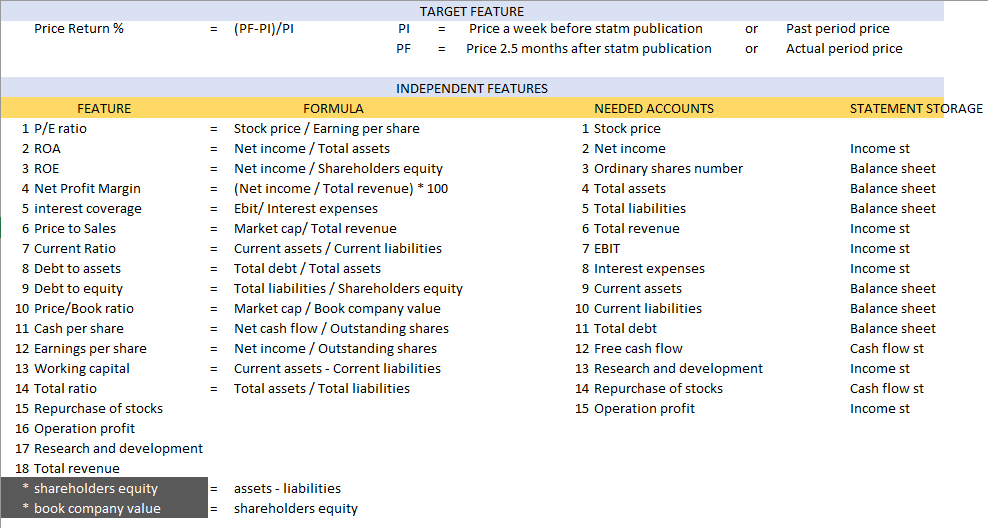

In [14]:
First_df['Shareholders Equity'] = First_df['totalAssets'] - First_df['totalLiab'] 
First_df['Market Cap'] = First_df['Initial Prices'] * First_df['Ordinary Shares Number']

First_df['Earnings per Share'] = First_df['netIncome'] / First_df['Ordinary Shares Number']
First_df['ROA'] = First_df['netIncome'] / First_df['totalAssets']
First_df['ROE'] = First_df['netIncome'] / First_df['Shareholders Equity']
First_df['Net Profit Margin'] = First_df['netIncome'] / First_df['totalRevenue']
First_df['Interest Coverage'] = First_df['ebit'] / First_df['interestExpense']
First_df['Price to Sales'] = First_df['Market Cap'] / First_df['totalRevenue']
First_df['Current Ratio'] = First_df['totalCurrentAssets'] / First_df['totalCurrentLiabilities']
First_df['Debt to Assets'] = First_df['Total Debt'] / First_df['totalAssets']
First_df['Debt to Equity'] = First_df['Total Debt'] / First_df['Shareholders Equity']
First_df['Price/Book Ratio'] = First_df['Market Cap'] / First_df['Shareholders Equity']
First_df['Cash per Share'] = First_df['Free Cash Flow'] / First_df['Ordinary Shares Number']
First_df['Working Capital '] = First_df['totalCurrentAssets'] - First_df['totalCurrentLiabilities']
First_df['Total Ratio'] = First_df['totalAssets'] / First_df['totalLiab']
First_df['P/E Ratio'] = First_df['Initial Prices'] / First_df['Earnings per Share']

In [15]:
First_df

,stock,endDate,netIncome,totalRevenue,ebit,researchDevelopment,operatingIncome,interestExpense,totalAssets,totalLiab,totalCurrentLiabilities,totalCurrentAssets,repurchaseOfStock,Initial Prices,Final Prices,Ordinary Shares Number,Total Debt,Free Cash Flow,Target,Shareholders Equity,Market Cap,Earnings per Share,ROA,ROE,Net Profit Margin,Interest Coverage,Price to Sales,Current Ratio,Debt to Assets,Debt to Equity,Price/Book Ratio,Cash per Share,Working Capital,Total Ratio,P/E Ratio
0,MSFT,2020-06-30,4.428100e+10,1.430150e+11,5.295900e+10,1.926900e+10,5.295900e+10,-2.591000e+09,3.013110e+11,1.830070e+11,7.231000e+10,1.819150e+11,-2.296800e+10,194.240005,208.779999,7571000.0,70998000.0,45234000.0,0.074856,1.183040e+11,1.470591e+09,5848.765024,0.146961,0.374298,0.309625,-20.439599,0.010283,2.515765,0.000236,0.000600,0.012431,5.974640,1.096050e+11,1.646445,0.033210
1,MSFT,2019-06-30,3.924000e+10,1.258430e+11,4.295900e+10,1.687600e+10,4.295900e+10,-2.686000e+09,2.865560e+11,1.842260e+11,6.942000e+10,1.755520e+11,-1.954300e+10,132.850006,136.330002,7643000.0,78366000.0,38260000.0,0.026195,1.023300e+11,1.015373e+09,5134.109643,0.136937,0.383465,0.311817,-15.993671,0.008069,2.528839,0.000273,0.000766,0.009923,5.005888,1.061320e+11,1.555459,0.025876
2,MSFT,2018-06-30,1.657100e+10,1.103600e+11,3.505800e+10,1.472600e+10,3.505800e+10,-2.733000e+09,2.588480e+11,1.761300e+11,5.848800e+10,1.696620e+11,-1.072100e+10,100.860001,112.139999,7677000.0,81808000.0,32252000.0,0.111838,8.271800e+10,7.743022e+08,2158.525466,0.064018,0.200331,0.150154,-12.827662,0.007016,2.900800,0.000316,0.000989,0.009361,4.201120,1.111740e+11,1.469642,0.046726
3,MSFT,2017-06-30,2.548900e+10,9.657100e+10,2.933100e+10,1.303700e+10,2.933100e+10,-2.222000e+09,2.503120e+11,1.626010e+11,5.574500e+10,1.626960e+11,-1.178800e+10,70.870003,75.309998,7708000.0,86194000.0,31378000.0,0.062650,8.771100e+10,5.462660e+08,3306.824079,0.101829,0.290602,0.263941,-13.200270,0.005657,2.918576,0.000344,0.000983,0.006228,4.070835,1.069510e+11,1.539425,0.021431
4,T,2020-12-31,-5.176000e+09,1.717600e+11,2.565600e+10,NaN,2.565600e+10,-7.925000e+09,5.257610e+11,3.465210e+11,6.343800e+10,5.200800e+10,-5.498000e+09,29.400000,30.010000,7125922.0,179447000.0,27455000.0,0.020748,1.792400e+11,2.095021e+08,-726.362147,-0.009845,-0.028877,-0.030135,-3.237350,0.001220,0.819824,0.000341,0.001001,0.001169,3.852835,-1.143000e+10,1.517256,-0.040476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,TV,2017-12-31,4.524496e+09,9.427424e+10,1.573163e+10,NaN,1.573163e+10,-9.151191e+09,2.972201e+11,1.975632e+11,5.076482e+10,8.704470e+10,-5.185726e+09,19.190001,15.380000,342337100.0,133403832.0,6562580.0,-0.198541,9.965691e+10,6.569449e+09,13.216493,0.015223,0.045401,0.047993,-1.719080,0.069684,1.714666,0.000449,0.001339,0.065921,0.019170,3.627989e+10,1.504431,1.451974
241,HERDEZ.MX,2020-12-31,8.279600e+08,2.403628e+10,2.878403e+09,NaN,2.878403e+09,-9.068970e+08,3.357465e+10,1.623819e+10,4.807349e+09,1.164078e+10,-1.132437e+09,40.029999,42.650002,341712.0,10293637.0,2121697.0,0.065451,1.733646e+10,1.367873e+07,2422.976073,0.024660,0.047758,0.034446,-3.173903,0.000569,2.421455,0.000307,0.000594,0.000789,6.209021,6.833431e+09,2.067635,0.016521
242,HERDEZ.MX,2019-12-31,1.014497e+09,2.242037e+10,2.898386e+09,NaN,2.898386e+09,-7.243140e+08,3.308143e+10,1.483378e+10,4.627921e+09,1.097466e+10,-9.007790e+08,38.490002,33.770000,380578.0,8859043.0,1670310.0,-0.122629,1.824766e+10,1.464845e+07,2665.674316,0.030667,0.055596,0.045249,-4.001560,0.000653,2.371401,0.000268,0.000485,0.000803,4.388877,6.346734e+09,2.230142,0.014439
243,HERDEZ.MX,2018-12-31,1.156258e+09,2.097068e+10,2.986002e+09,NaN,2.986002e+09,-5.982280e+08,2.964000e+10,1.139035e+10,3.703781e+09,9.804335e+09,-2.807470e+08,39.290001,43.020000,421611.0,6638259.0,1591127.0,0.094935,1.824965e+10,1.656510e+07,2742.475884,0.039010,0.063358,0.055137,-4.991411,0.000790,2.64711

In [16]:
First_df = First_df.drop(['Final Prices', 'Initial Prices'], axis= 1)

In [17]:
# Check columns index
First_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   stock                    245 non-null    object 
 1   endDate                  245 non-null    object 
 2   netIncome                245 non-null    float64
 3   totalRevenue             245 non-null    float64
 4   ebit                     245 non-null    float64
 5   researchDevelopment      129 non-null    float64
 6   operatingIncome          245 non-null    float64
 7   interestExpense          243 non-null    float64
 8   totalAssets              245 non-null    float64
 9   totalLiab                245 non-null    float64
 10  totalCurrentLiabilities  245 non-null    float64
 11  totalCurrentAssets       245 non-null    float64
 12  repurchaseOfStock        202 non-null    float64
 13  Ordinary Shares Number   245 non-null    float64
 14  Total Debt               2

In [18]:
Ratios_DF = First_df.iloc[:,[16,0,1,3,5,6,12,19,20,21,22,23,24,25,26,27,28,29,30,31,32]]
Ratios_DF

,Target,stock,endDate,totalRevenue,researchDevelopment,operatingIncome,repurchaseOfStock,Earnings per Share,ROA,ROE,Net Profit Margin,Interest Coverage,Price to Sales,Current Ratio,Debt to Assets,Debt to Equity,Price/Book Ratio,Cash per Share,Working Capital,Total Ratio,P/E Ratio
0,0.074856,MSFT,2020-06-30,1.430150e+11,1.926900e+10,5.295900e+10,-2.296800e+10,5848.765024,0.146961,0.374298,0.309625,-20.439599,0.010283,2.515765,0.000236,0.000600,0.012431,5.974640,1.096050e+11,1.646445,0.033210
1,0.026195,MSFT,2019-06-30,1.258430e+11,1.687600e+10,4.295900e+10,-1.954300e+10,5134.109643,0.136937,0.383465,0.311817,-15.993671,0.008069,2.528839,0.000273,0.000766,0.009923,5.005888,1.061320e+11,1.555459,0.025876
2,0.111838,MSFT,2018-06-30,1.103600e+11,1.472600e+10,3.505800e+10,-1.072100e+10,2158.525466,0.064018,0.200331,0.150154,-12.827662,0.007016,2.900800,0.000316,0.000989,0.009361,4.201120,1.111740e+11,1.469642,0.046726
3,0.062650,MSFT,2017-06-30,9.657100e+10,1.303700e+10,2.933100e+10,-1.178800e+10,3306.824079,0.101829,0.290602,0.263941,-13.200270,0.005657,2.918576,0.000344,0.000983,0.006228,4.070835,1.069510e+11,1.539425,0.021431
4,0.020748,T,2020-12-31,1.717600e+11,NaN,2.565600e+10,-5.498000e+09,-726.362147,-0.009845,-0.028877,-0.030135,-3.237350,0.001220,0.819824,0.000341,0.001001,0.001169,3.852835,-1.143000e+10,1.517256,-0.040476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,-0.198541,TV,2017-12-31,9.427424e+10,NaN,1.573163e+10,-5.185726e+09,13.216493,0.015223,0.045401,0.047993,-1.719080,0.069684,1.714666,0.000449,0.001339,0.065921,0.019170,3.627989e+10,1.504431,1.451974
241,0.065451,HERDEZ.MX,2020-12-31,2.403628e+10,NaN,2.878403e+09,-1.132437e+09,2422.976073,0.024660,0.047758,0.034446,-3.173903,0.000569,2.421455,0.000307,0.000594,0.000789,6.209021,6.833431e+09,2.067635,0.016521
242,-0.122629,HERDEZ.MX,2019-12-31,2.242037e+10,NaN,2.898386e+09,-9.007790e+08,2665.674316,0.030667,0.055596,0.045249,-4.001560,0.000653,2.371401,0.000268,0.000485,0.000803,4.388877,6.346734e+09,2.230142,0.014439
243,0.094935,HERDEZ.MX,2018-12-31,2.097068e+10,NaN,2.986002e+09,-2.807470e+08,2742.475884,0.039010,0.063358,0.055137,-4.991411,0.000790,2.647115,0.000224,0.000364,0.000908,3.773922,6.100554e+09,2.602203,0.014326


In [19]:
Ratios_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Target               245 non-null    float64
 1   stock                245 non-null    object 
 2   endDate              245 non-null    object 
 3   totalRevenue         245 non-null    float64
 4   researchDevelopment  129 non-null    float64
 5   operatingIncome      245 non-null    float64
 6   repurchaseOfStock    202 non-null    float64
 7   Earnings per Share   245 non-null    float64
 8   ROA                  245 non-null    float64
 9   ROE                  245 non-null    float64
 10  Net Profit Margin    245 non-null    float64
 11  Interest Coverage    243 non-null    float64
 12  Price to Sales       245 non-null    float64
 13  Current Ratio        245 non-null    float64
 14  Debt to Assets       243 non-null    float64
 15  Debt to Equity       243 non-null    flo

In [20]:
#Ratios_DF_2index = Ratios_DF.groupby(by=["stock"]).cumcount
#df.groupby(level=0).cumcount()
len(Ratios_DF)

245

In [34]:
def Features_creator(col):
  Account_change = []
  row = 0
  while row < (len(Ratios_DF)-1):
    Account_change_row = (Ratios_DF.iloc[row, col] - Ratios_DF.iloc[row + 1, col]) / Ratios_DF.iloc[row + 1, col]
    Account_change.append(Account_change_row)
    row = 1 + row
  Account_change.append(0)  
  return Account_change

In [ ]:
Features_creator(3)

In [37]:
len(Account_change)

245

In [ ]:
Ratios_DF['test'] = Account_change

In [31]:
Ratios_DF

,Target,stock,endDate,totalRevenue,researchDevelopment,operatingIncome,repurchaseOfStock,Earnings per Share,ROA,ROE,Net Profit Margin,Interest Coverage,Price to Sales,Current Ratio,Debt to Assets,Debt to Equity,Price/Book Ratio,Cash per Share,Working Capital,Total Ratio,P/E Ratio,test
0,0.074856,MSFT,2020-06-30,1.430150e+11,1.926900e+10,5.295900e+10,-2.296800e+10,5848.765024,0.146961,0.374298,0.309625,-20.439599,0.010283,2.515765,0.000236,0.000600,0.012431,5.974640,1.096050e+11,1.646445,0.033210,0.136456
1,0.026195,MSFT,2019-06-30,1.258430e+11,1.687600e+10,4.295900e+10,-1.954300e+10,5134.109643,0.136937,0.383465,0.311817,-15.993671,0.008069,2.528839,0.000273,0.000766,0.009923,5.005888,1.061320e+11,1.555459,0.025876,0.140295
2,0.111838,MSFT,2018-06-30,1.103600e+11,1.472600e+10,3.505800e+10,-1.072100e+10,2158.525466,0.064018,0.200331,0.150154,-12.827662,0.007016,2.900800,0.000316,0.000989,0.009361,4.201120,1.111740e+11,1.469642,0.046726,0.142786
3,0.062650,MSFT,2017-06-30,9.657100e+10,1.303700e+10,2.933100e+10,-1.178800e+10,3306.824079,0.101829,0.290602,0.263941,-13.200270,0.005657,2.918576,0.000344,0.000983,0.006228,4.070835,1.069510e+11,1.539425,0.021431,-0.437756
4,0.020748,T,2020-12-31,1.717600e+11,NaN,2.565600e+10,-5.498000e+09,-726.362147,-0.009845,-0.028877,-0.030135,-3.237350,0.001220,0.819824,0.000341,0.001001,0.001169,3.852835,-1.143000e+10,1.517256,-0.040476,-0.052061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,-0.198541,TV,2017-12-31,9.427424e+10,NaN,1.573163e+10,-5.185726e+09,13.216493,0.015223,0.045401,0.047993,-1.719080,0.069684,1.714666,0.000449,0.001339,0.065921,0.019170,3.627989e+10,1.504431,1.451974,2.922164
241,0.065451,HERDEZ.MX,2020-12-31,2.403628e+10,NaN,2.878403e+09,-1.132437e+09,2422.976073,0.024660,0.047758,0.034446,-3.173903,0.000569,2.421455,0.000307,0.000594,0.000789,6.209021,6.833431e+09,2.067635,0.016521,0.072073
242,-0.122629,HERDEZ.MX,2019-12-31,2.242037e+10,NaN,2.898386e+09,-9.007790e+08,2665.674316,0.030667,0.055596,0.045249,-4.001560,0.000653,2.371401,0.000268,0.000485,0.000803,4.388877,6.346734e+09,2.230142,0.014439,0.069129
243,0.094935,HERDEZ.MX,2018-12-31,2.097068e+10,NaN,2.986002e+09,-2.807470e+08,2742.475884,0.039010,0.063358,0.055137,-4.991411,0.000790,2.647115,0.000224,0.000364,0.000908,3.773922,6.100554e+09,2.602203,0.014326,0.045142


In [51]:
def mult_features_creator(cols):
  print ('getting returns for row' + str(row) + 'from column' + str(col))
  return pd.concat([pd.Series(Features_creator(col)) for col in cols], axis=1)

  # lists = [lst1, lst2, lst3, lst4]
  # df = pd.concat([pd.Series(x) for x in lists], axis=1)

In [53]:
cols = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
mult_features_creator(cols)

getting returns for row244from column3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.136456,0.141799,0.232780,0.175255,0.139198,0.073206,-0.023905,-0.007031,0.277980,0.274424,-0.005170,-0.138386,-0.216350,0.252766,0.193523,0.032723,0.058495,0.283447
1,0.140295,0.146000,0.225369,0.822871,1.378526,1.139024,0.914156,1.076648,0.246811,0.149999,-0.128227,-0.134699,-0.225665,0.060015,0.191560,-0.045352,0.058393,-0.446223
2,0.142786,0.129554,0.195254,-0.090516,-0.347251,-0.371315,-0.310634,-0.431107,-0.028227,0.240342,-0.006090,-0.082184,0.006405,0.503005,0.032004,0.039485,-0.045331,1.180271
3,-0.437756,NaN,0.143241,1.144052,-5.552583,-11.343445,-11.063276,-9.758583,3.077492,3.637576,2.560002,0.008899,-0.018429,4.328398,0.056582,-10.357043,0.014611,-1.529489
4,-0.052061,NaN,-0.075160,1.274721,-1.379014,-1.390639,-1.419431,-1.392740,-0.017160,-0.213611,0.031663,0.018051,0.093085,-0.160168,-0.043868,-0.192226,-0.038123,-3.002314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,2.922164,NaN,4.465401,3.579262,-0.994545,-0.382703,-0.049365,0.393269,-0.458370,121.449601,-0.291886,0.463972,1.254512,82.548031,-0.996913,4.309176,-0.272391,86.886527
241,0.072073,NaN,-0.006895,0.257175,-0.091046,-0.195861,-0.140976,-0.238738,-0.206834,-0.128977,0.021108,0.144866,0.223006,-0.017119,0.414718,0.076685,-0.072868,0.144183
242,0.069129,NaN,-0.029342,2.208508,-0.028004,-0.213878,-0.122508,-0.179335,-0.198311,-0.172882,-0.104157,0.195712,0.334689,-0.115608,0.162949,0.040354,-0.142979,0.007863
243,0.045142,NaN,0.061539,0.809881,0.123480,0.038394,0.050308,0.057552,0.017644,-0.191245,0.001493,-0.017999,-0.006732,-0.196785,0.218180,0.188764,-0.018383,-0.235257
